In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import pickle
try:
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)

In [2]:
import pickle
try:
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)
    
except:
    exec(open('./Data.py').read())
    with open('df.pickle', 'rb') as f:
        df = pickle.load(f)

In [3]:
df.head()

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG,Type,AfterGenusErection,BeforeGenusErection,DuringGenusErection
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2,True,False,False,True
1,2,STRUTHIONIFORMES,Struthionidae,Struthio,molybdophanes,AF,True,1883,[reichenow],1758,[linnaeus],2,2,False,True,True,False
2,1,RHEIFORMES,Rheidae,Rhea,americana,SA,False,1758,[linnaeus],1760,[brisson],1,2,True,False,False,False
3,2,RHEIFORMES,Rheidae,Rhea,pennata,SA,True,1834,[d'orbigny],1760,[brisson],2,2,False,True,True,False
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5,True,False,False,True


## Initial EDA



The collected data contains the the following information. All taken from the IOC's 8.1 list:  

1. "Rank" - maybe better called "Sequence" - the order in which the species appears in the IOC's 8.1 list. This rank/sequence is supposed to start with the "least derived" species in the Genus, and end with the "most derived" species in the Genus.  
2. "Order" - Order to which the species belongs  
3. "Family" - Family to which the species belongs  
4. "Genus" - Genus to which the species belongs  
5. "Species" - specific epithet  
6. "BreedRegion" - Part of the world in which the species is known to breed  
7. "OrigG" - Whether or not the species is currently part of the Genus in which it was first described  
8. "SDate" - The date of first description of the species
9. "SDate" - A list of the authors credited with the species description  
10. "GDate" - The date of description for the Genus  
11. "GAuthors" - A list of the authors credited with the Genus description  
12. "DateRank" - The order in which the species was described (calculated from "SDate"). In the event of a tie, both species are awarded the higher rank. E.G. 1,2,3,3,5  
13. "SpG" - The number of species per Genus  
14. "Type" - Indicates whetehr or not the species was designated a 'type species' in the IOC's 7.3 list

*A notable omission from this data is subspecies information*


In [ ]:
# Create GRank information

For the purposes of this investigation, I will focus on the manner (in particular the distributions) of how species are split into Genera.  

As a way of starting: How much of the species rank/sequence information is contained within various details of the description, in particular, the date rank? 

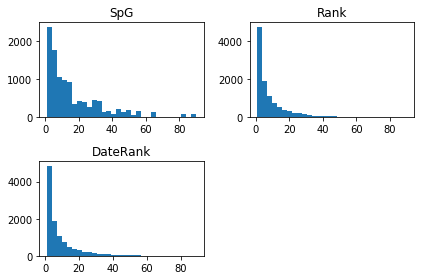

In [44]:
plt.figure(figsize = (6,4));i = 0
for c in ['SpG', 'Rank','DateRank']:
    i+=1
    plt.subplot(2,2,i); plt.title(c)
    plt.hist(df[c], bins = 30)
plt.tight_layout()

The Rank and DateRank distributions look virtually identical, which is expected.  

The drop-off in species per Genus around 15 is certainly interesting: A closer Look:

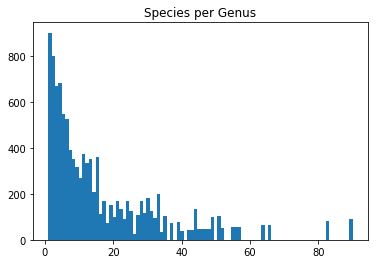

In [72]:
h = plt.hist(df['SpG'], bins = 90);
plt.title('Species per Genus');

The above graphics are misleading in that the counts displayed are done species-by-species. Thus the resulting histogram is of species per Genus TIMES species. E.g. the genera with 90 species displays with the value of 90 instead of 1.  

Below is the distribution of genera at every species per Genus level.

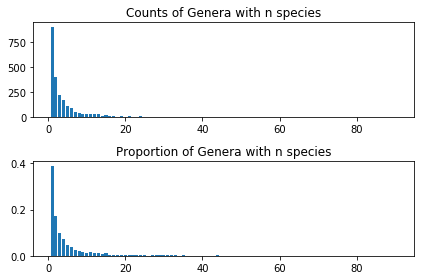

In [148]:
dat = df['SpG'].value_counts().sort_index() / df['SpG'].value_counts().sort_index().index

plt.subplot(211)
plt.bar(dat.index, dat)
plt.title('Counts of Genera with n species')

plt.subplot(212)
plt.bar(dat.index, dat / dat.sum())
plt.title('Proportion of Genera with n species')

plt.tight_layout()

A close-up between 12 and 25 SpG

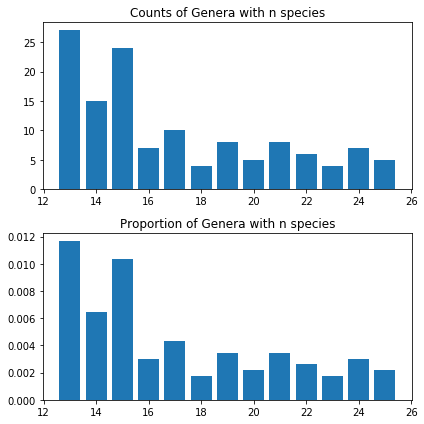

In [135]:
plt.figure(figsize = (6,6))

plt.subplot(211)
plt.bar(dat.index[12:25], dat[12:25])
plt.title('Counts of Genera with n species')

plt.subplot(212)
plt.bar(dat.index[12:25], dat[12:25] / dat.sum())
plt.title('Proportion of Genera with n species')

plt.tight_layout()

Now, looking more closely at the distribution of Date Rank, as it relates to the  Sequence-Rank.  

First: for the lower species per Genus Genera, Given a certain Sequence-Rank, how many species exhibit each Date-Rank

In [141]:
def plotSpg(data, num):
    df = data[data['SpG']==num]
    ymax = len(df[(df['SpG']==num) & (df['Rank']==1) & (df['DateRank']==1)])+5
    row = int(num/3)+1
    for i in range(1,num+1):
        plt.subplot(row,3,i)
        plt.hist(df[df['Rank'] ==i]['DateRank'])
        
        plt.ylim(ymax = ymax)
        plt.title('Rank = '+ str(i))
        plt.xlabel('Date Rank')

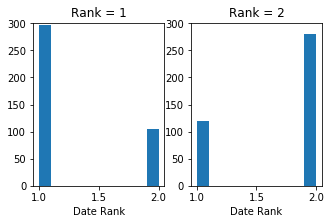

In [142]:
plt.figure(figsize = (8,3))
plotSpg(df,2)

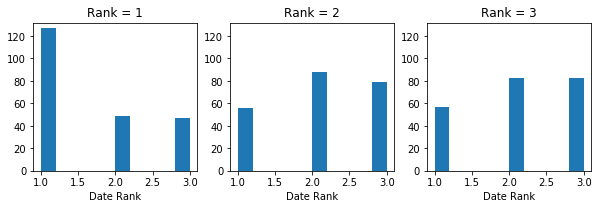

In [143]:
plt.figure(figsize = (10,6))
plotSpg(df,3)

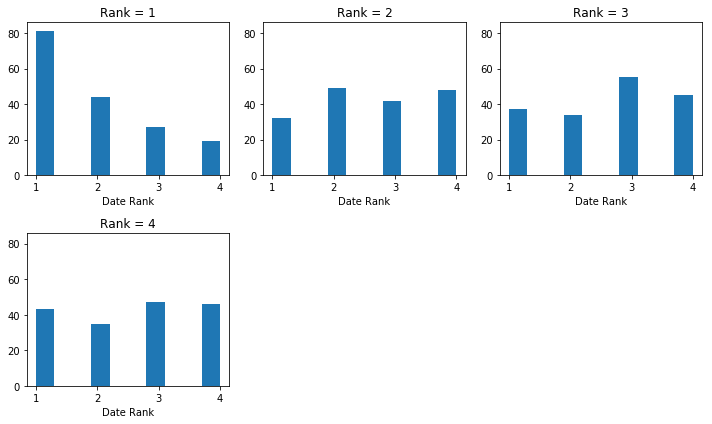

In [144]:
plt.figure(figsize = (10,6))
plotSpg(df,4)
plt.tight_layout()

Here, the number of species where are given sequence-rank 1, and were also described first seems to be notably higher than any other sequence-rank / date rank pairing.

In [436]:
exec(open('./Data.py').read())

200


In [350]:
data = df

init opts [('SDate > GDate', False), ('Type', None), ('OrigG', None), ('SDate', [1750, 1900])]
 Not SDate > GDate  Epoch 1750 to 1900 
Wall time: 1.91 s


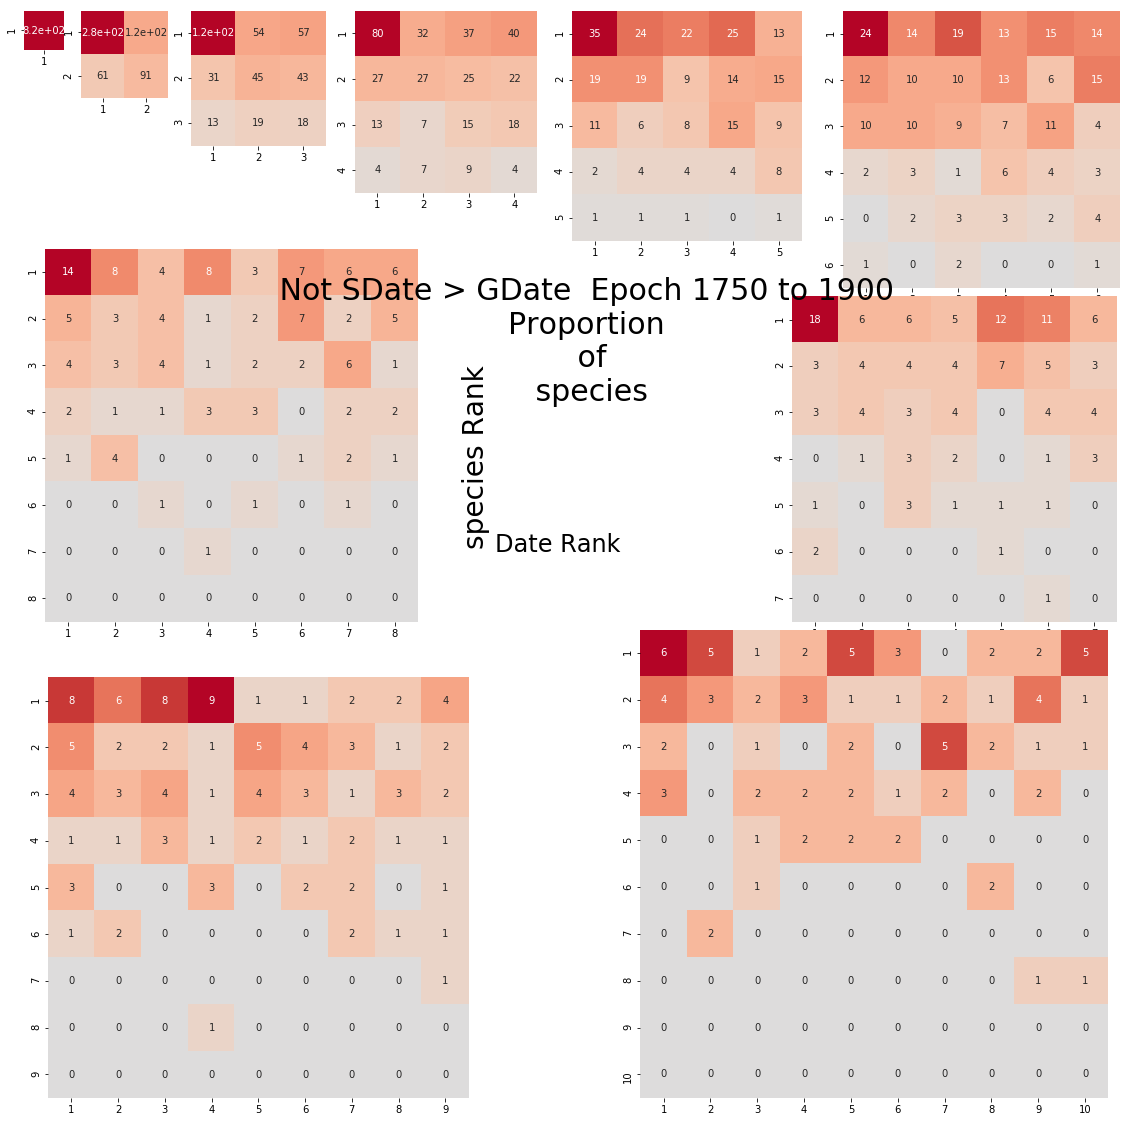

In [435]:
%%time
# creates functions:
# authorcounts
exec(open('./VisualizeFuncs.py').read())
exec(open('./GroupingClasses.py').read())
hn = showPlot(df, kind = 'unagg', num = 'All', SDateVGDate= False, Epoch= [1750, 1900], func = 'count')

In [404]:
[] != None

True

In [383]:
mopts = [('',None),('Type',True),('OrigG',None),('',None)]

In [398]:
tn = TreeNode(value = ('',None))
tn.value

('', None)

In [397]:
hn.children[0].value

''

In [385]:
hn = TreeNode()
buildTree( mopts, hn)

[[['', ('Type', True)], 'OrigG'], '']
[[['', ('Type', True)], 'OrigG'], '']
Error <class 'str'>


ValueError: not enough values to unpack (expected 2, got 0)

[('', None), ('Type', True), ('OrigG', None), ('', None)]
[[[('', None), ('Type', True)], ('OrigG', None)], ('', None)]
[[[('', None), ('Type', True)], ('OrigG', None)], ('', None)]
Error <class 'tuple'>
[[[('', None), ('Type', False)], ('OrigG', None)], ('', None)]
[[[('', None), ('Type', False)], ('OrigG', None)], ('', None)]
Error <class 'tuple'>


In [333]:
%%time
r = tableReturn(headNode)

Wall time: 0 ns


In [334]:
for e in r:
    print(e[0])

[('OrigG', True), ('Type', True)]
[('OrigG', True), ('Type', False)]
[('OrigG', False), ('Type', True)]
[('OrigG', False), ('Type', False)]


In [335]:
tabCounter(headNode)

4

SyntaxError: invalid syntax (<ipython-input-336-7b26664886c4>, line 1)

In [ ]:
m = (df['Type'] == False) 
m 

In [153]:
mopts = [('OrigG',True), ('Type',False)]

#df[makeMask([])].head()

In [157]:
makeBoolChildrenVals

NameError: name 'makeBoolChildrenVals' is not defined

In [180]:
if headNode.children[0].parent.value == None:
    print(headNode.children[0].value)

('OrigG', True)


In [202]:
headNode.return_val()

('', None)

In [201]:
headNode.children[0].children

[n2, ]

In [228]:
n1 = headNode.children[0]
n4 = headNode.children[1]
n2 = n1.children[0]
n3 = n1.children[1]
n5 = n4.children[0]
n6 = n4.children[1]
n1.set_name('n1')
n2.set_name('n2')
n3.set_name('n3')
n4.set_name('n4')
n5.set_name('n5')
n6.set_name('n6')

In [279]:
for n in [n1, n2, n3, n4, n5, n6]:
    print(n, n.return_val())

here
n1 ('OrigG', True)
('Type', True)
here
n2 [('OrigG', True), ('Type', True)]
('Type', False)
here
n3 [('OrigG', True), ('Type', False)]
here
n4 ('OrigG', False)
('Type', True)
here
n5 [('OrigG', False), ('Type', True)]
('Type', False)
here
n6 [('OrigG', False), ('Type', False)]


In [208]:
mopts = n2.return_val()

('Type', True)
here


In [216]:
m = makeMask(mopts)

In [ ]:
tableReturn(headNode)

In [229]:
def tableReturn(node, toRet = []):
    if node.children != []:
        for c in node.children:
            toRet.extend(tableReturn(c, toRet))
    else:
        toRet.append((self.options, self.table))
        return toRet

    return toRet

In [271]:
l = [1,2,3]
l2 = [4,5]
l+=l2
l

[1, 2, 3, 4, 5]

In [225]:
headNode = TreeNode()
buildTree(mopts, headNode)
#print(headNode.parent)

('Type', True)
here
('Type', False)
here
('Type', True)
here
('Type', False)
here


### Drop Unneeded Columns

In [26]:
data = df

In [181]:
dfp = df.drop(['Order', 'Family','BreedRegion','GAuthors', 'SAuthors'], axis = 'columns')

realGrouped = speciesGrouper(dfp)
realtabs = tableMaker(realGrouped)
realAgg = speciesRankDateAgg(realtabs)

randomR = randomizeRank(dfp)
alphaR = alphaRank(dfp)

randomAgg = fullAgg(randomR)

In [ ]:
[True, True, False, True, False]

In [228]:
def showPlot(source = 'real', kind = 'agg', num = 1, spgDiscard = [1], func = prop,
             AfterGenusErection = False, BeforeGenusErection = False, DuringGenusErection = False,
            Type = False, OrigGenus = False, Epoch = False, EpochType = 's'):
    
    def returnGBLists():
        
        toGroup = ['SpG', 'Rank', 'DateRank']
        for boolean, name in zip([AfterGenusErection, BeforeGenusErection, DuringGenusErection, Type, OrigGenus],
                                ['AfterGenusErection', 'BeforeGenusErection', 'DuringGenusErection', 'Type', 'OrigG']):
            if boolean:
                toGroup.append(name)
        toGroupNames = toGroup.copy()
        
        if Epoch:
            splitDict = {'s': 'SDate', 'g':'GDate'}
            if EpochType in splitDict.keys():
                splitter = splitDict[EpochType]
                
            else: # Add exception statement
                print('bad EpochType')
                
            if Epoch == True:
                epochs = [1758, 1815, 1916, 2020]
            else:
                epochs = Epoch
            toGroupNames.append('Epoch')        
            toGroup.append(pd.cut(df[splitter], epochs))
            
        return toGroup, toGroupNames
    
    def returnData():
        sourceDict = {'real' : lambda x:x, 'alpha': alphaRank, 'random': randomizeRank}
        
        if source in sourceDict.keys():
            return sourceDict[source](df)
        else: # make exception statement
            print('Bad Source Argument')
    def makeOptionDicts():
        opts = {opt: list(grouped[opt].unique())
            for opt in gbListNames
                if opt not in ['SpG', 'Rank','DateRank']}
        def dictCompile():
            individualDicts = []

            for k in opts:
                individualDicts.append([{k:v} for v in opts[k]])

            return dictMaker(individualDicts)
        
        def dictMaker(lst):
            toRet = []
            for d in lst[0]:
                if len(lst)>1:
                    for ds in dictMaker(lst[1:]):
                        toRet.append(dict(d,**ds))
                else:
                    return lst[0]
            return toRet
        
        return dictCompile()
        
    data = returnData()
    
    gbList, gbListNames = returnGBLists()
    
    
    
    grouped = speciesGrouper(data, gbList = gbList, gbListNames= gbListNames)
    if kind == 'unAgg':
        
    return makeOptionDicts()
    tabs = splitToTables(grouped)
    return tabs
    agg = speciesRankDateAgg(tabs[True])
    aggHeatMapper(agg)

In [229]:
list(df['Type'].unique())

[True, False]

In [249]:
type(False) == bool

True

In [260]:
temp

,1,2,3,4
1,0.000000,0.000000,NaN,1.538462
2,1.538462,1.153846,NaN,0.000000
3,0.000000,0.384615,NaN,0.000000
4,0.000000,0.000000,NaN,0.000000


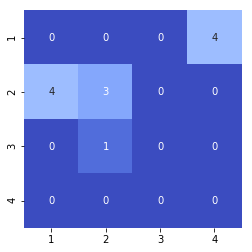

In [262]:
spg = 4
temp = pd.DataFrame({1: [0, 3, 0, 0], 2: [0, 3, 1, 0], 4: [1, 0, 0, 0], 3: [0, 0, 0, 0]})
temp.index = range(1,spg+1)
annots = temp.copy()
for dRank in temp:
    drObs = temp[dRank].sum()
    exp = drObs / spg

    temp[dRank] = [prop(sp, exp, drObs) for sp in temp[dRank]]
    annots[dRank] = temp[dRank].copy()
    temp[dRank] = [calc/2.6 for calc in temp[dRank]]

#where = locs[i]
#plt.subplot2grid((23,21),(where[0]-1, where[1]-1), colspan = i, rowspan = i)
sns.heatmap(temp, annot = annots, center = 2.6,
            cmap = 'coolwarm', square = True, cbar = False)

In [254]:
pd.DataFrame({1: [0, 3, 0, 0], 2: [0, 3, 1, 0], 4: [1, 0, 0, 0], 3: [0, 0, 0, 0]})

,1,2,3,4
0,0,0,0,1
1,3,3,0,0
2,0,1,0,0
3,0,0,0,0


{1: [0, 3, 0, 0], 2: [0, 3, 1, 0], 4: [1, 0, 0, 0], 3: [0, 0, 0, 0]}
Wall time: 23.1 s


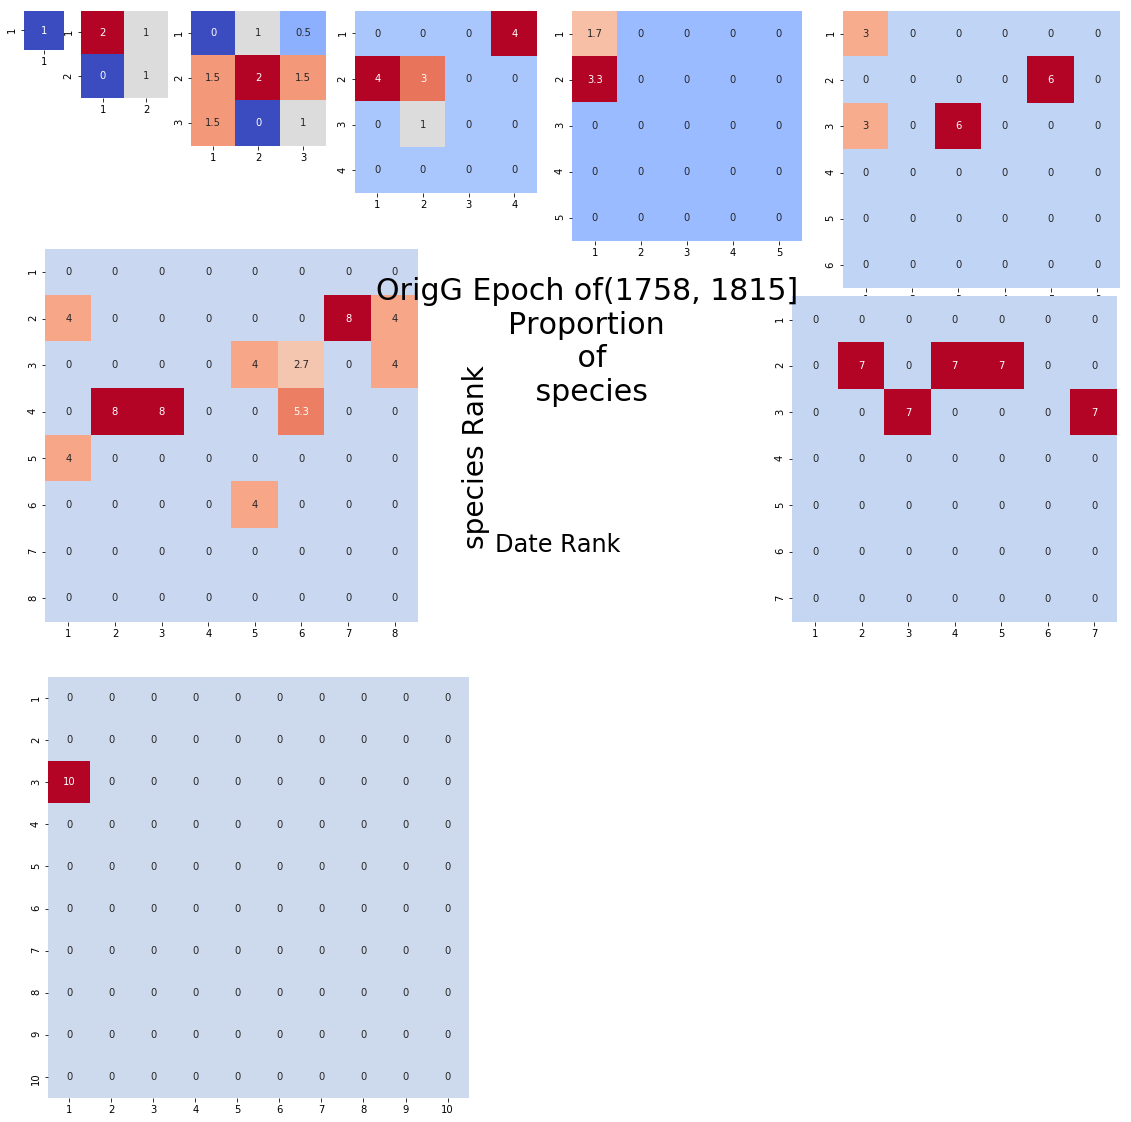

In [263]:
%%time
exec(open('./VisualizeFuncs.py').read())
exec(open('./showPlot.py').read())
showPlot(kind = 'unagg', OrigGenus= True, Epoch = True )

In [272]:
df.head()

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG,Type,AfterGenusErection,BeforeGenusErection,DuringGenusErection
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2,True,False,False,True
1,2,STRUTHIONIFORMES,Struthionidae,Struthio,molybdophanes,AF,True,1883,[reichenow],1758,[linnaeus],2,2,False,True,True,False
2,1,RHEIFORMES,Rheidae,Rhea,americana,SA,False,1758,[linnaeus],1760,[brisson],1,2,True,False,False,False
3,2,RHEIFORMES,Rheidae,Rhea,pennata,SA,True,1834,[d'orbigny],1760,[brisson],2,2,False,True,True,False
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5,True,False,False,True


In [274]:
mask = (df['Type'] == True)
mask = mask & (df['OrigG'] == True)

df[mask].head()

,Rank,Order,Family,Genus,Species,BreedRegion,OrigG,SDate,SAuthors,GDate,GAuthors,DateRank,SpG,Type,AfterGenusErection,BeforeGenusErection,DuringGenusErection
0,1,STRUTHIONIFORMES,Struthionidae,Struthio,camelus,AF,True,1758,[linnaeus],1758,[linnaeus],1,2,True,False,False,True
4,1,APTERYGIFORMES,Apterygidae,Apteryx,australis,AU,True,1813,[shaw],1813,[shaw],1,5,True,False,False,True
56,1,TINAMIFORMES,Tinamidae,Eudromia,elegans,SA,True,1832,"[geoffroy, saint-hilaire i]",1832,"[geoffroy, saint-hilaire i]",1,2,True,False,False,True
58,1,TINAMIFORMES,Tinamidae,Tinamotis,pentlandii,SA,True,1837,[vigors],1837,[vigors],1,2,True,False,False,True
166,10,ANSERIFORMES,Anatidae,Anas,platyrhynchos,NA EU,True,1758,[linnaeus],1758,[linnaeus],1,32,True,False,False,True


In [276]:
for ele in l:
    n, v = ele
    print(n)

1
3
5
4


In [275]:
l = [(1,2), (3,4)]
e = [(5,6),(4,5)]
l.extend(e)
l

[(1, 2), (3, 4), (5, 6), (4, 5)]

In [271]:
for i in []:
    print('hi')

In [270]:
for i in range(1,26):
    print(int(i**.5) if (i**.5).is_integer() else (int(i**.5)+1))

1
2
2
2
3
3
3
3
3
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5


In [265]:
l = []
l == []

True

In [232]:
print(Interval(1758, 1815))

NameError: name 'Interval' is not defined

In [239]:
dct = {True:{True:{True:[0,1]}}}
l = [True, True, True]
def dictionaryAccessor(dct, keys):
        for k in keys: dct = dct[k]
        return dct

dictionaryAccessor(dct, l)

[0, 1]

In [264]:
type(None) == None

False

In [234]:
ts

[{'AfterGenusErection': False,
  'Epoch': Interval(1758, 1815, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': False,
  'Epoch': Interval(1815, 1916, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': False,
  'Epoch': Interval(1916, 2020, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': False,
  'Epoch': Interval(1758, 1815, closed='right'),
  'OrigG': True},
 {'AfterGenusErection': False,
  'Epoch': Interval(1815, 1916, closed='right'),
  'OrigG': True},
 {'AfterGenusErection': False,
  'Epoch': Interval(1916, 2020, closed='right'),
  'OrigG': True},
 {'AfterGenusErection': True,
  'Epoch': Interval(1758, 1815, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': True,
  'Epoch': Interval(1815, 1916, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': True,
  'Epoch': Interval(1916, 2020, closed='right'),
  'OrigG': False},
 {'AfterGenusErection': True,
  'Epoch': Interval(1758, 1815, closed='right'),
  'OrigG': True},
 {'AfterGenusErect

In [151]:
typeGrouped = speciesGrouper(dfp, gbList=['SpG','Rank','DateRank', 'Type'] , gbListNames= ['SpG','Rank','DateRank', 'Type'])

In [171]:
typeTabs = splitToTables(typeGrouped)

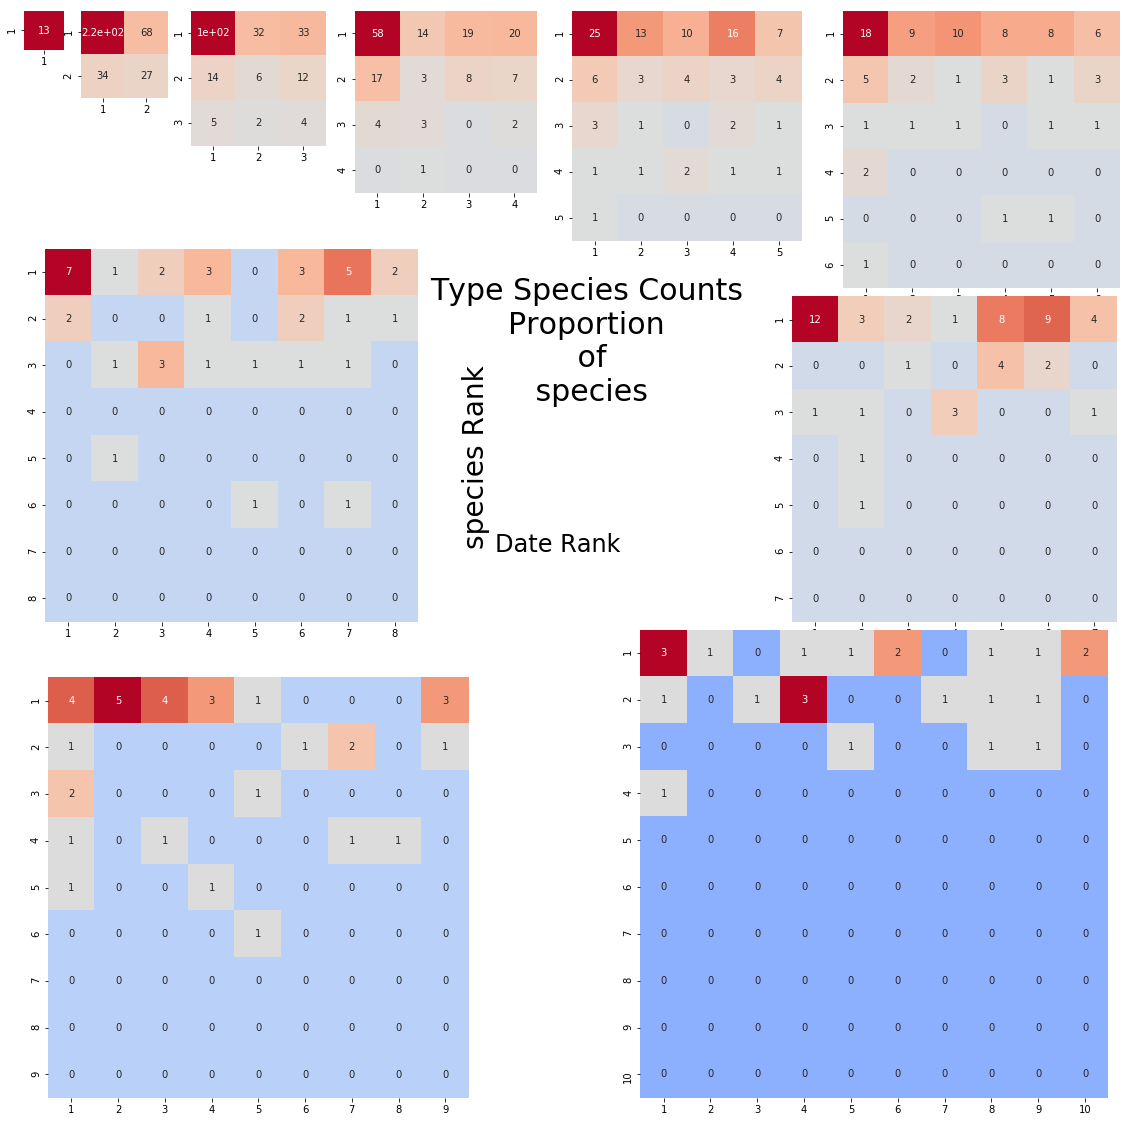

In [179]:
unaggHeatMapper(typeTabs[True], func = counts, title = 'Type Species Counts')

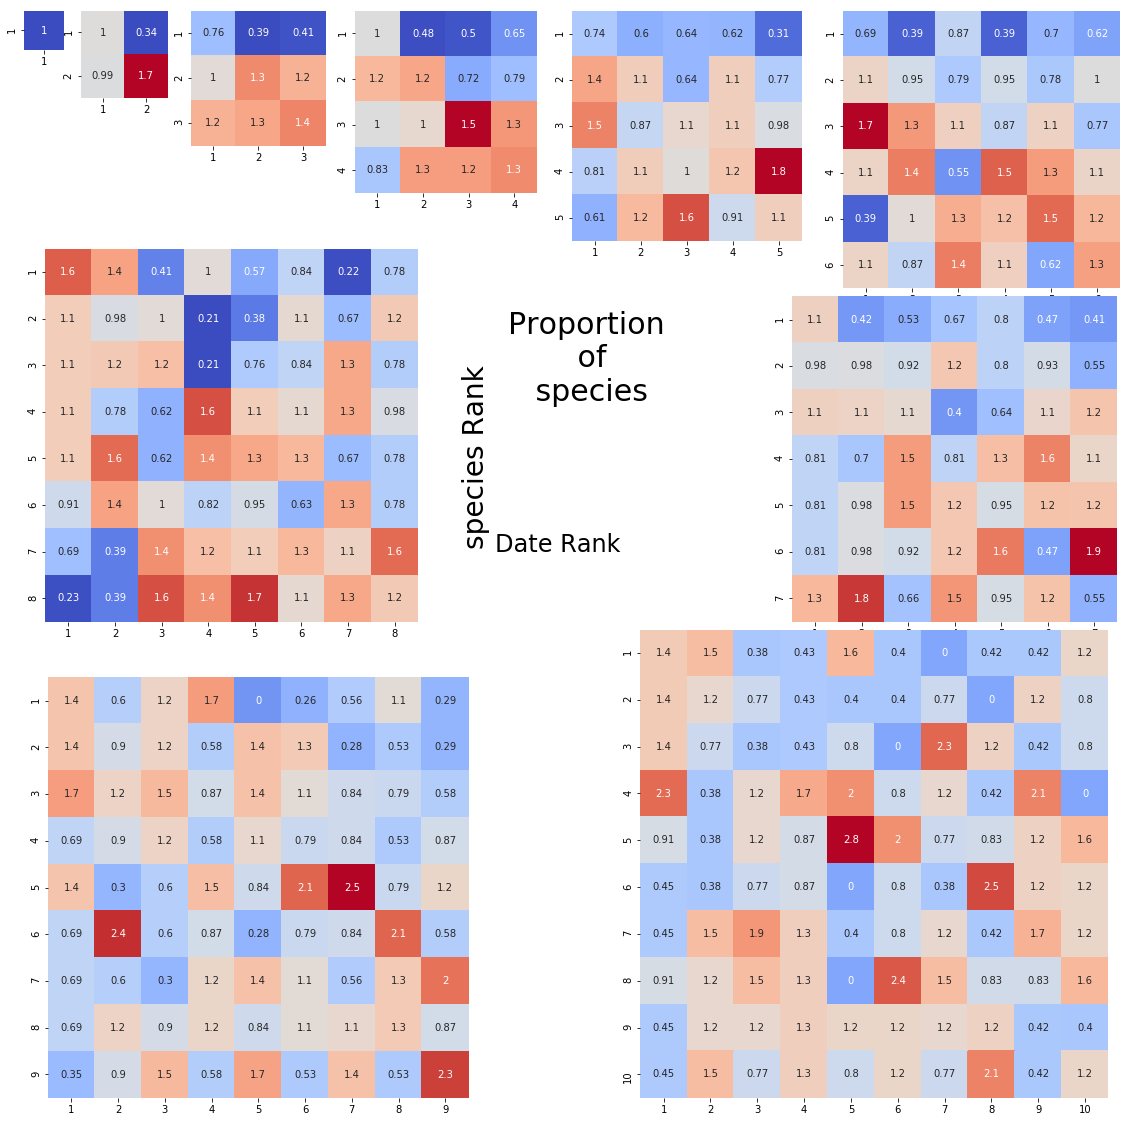

In [174]:
unaggHeatMapper(typeTabs[False])

In [156]:
toSplit = [col for col in typeGrouped.columns if col not in ['SpG','Rank', 'DateRank', 'Species']]

In [157]:
toSplit

['Type']

In [152]:
typeGrouped.head()

,Species,SpG,Rank,DateRank,Type
0,889,1.0,1.0,1.0,False
1,13,1.0,1.0,1.0,True
2,71,2.0,1.0,1.0,False
3,225,2.0,1.0,1.0,True
4,70,2.0,1.0,2.0,False


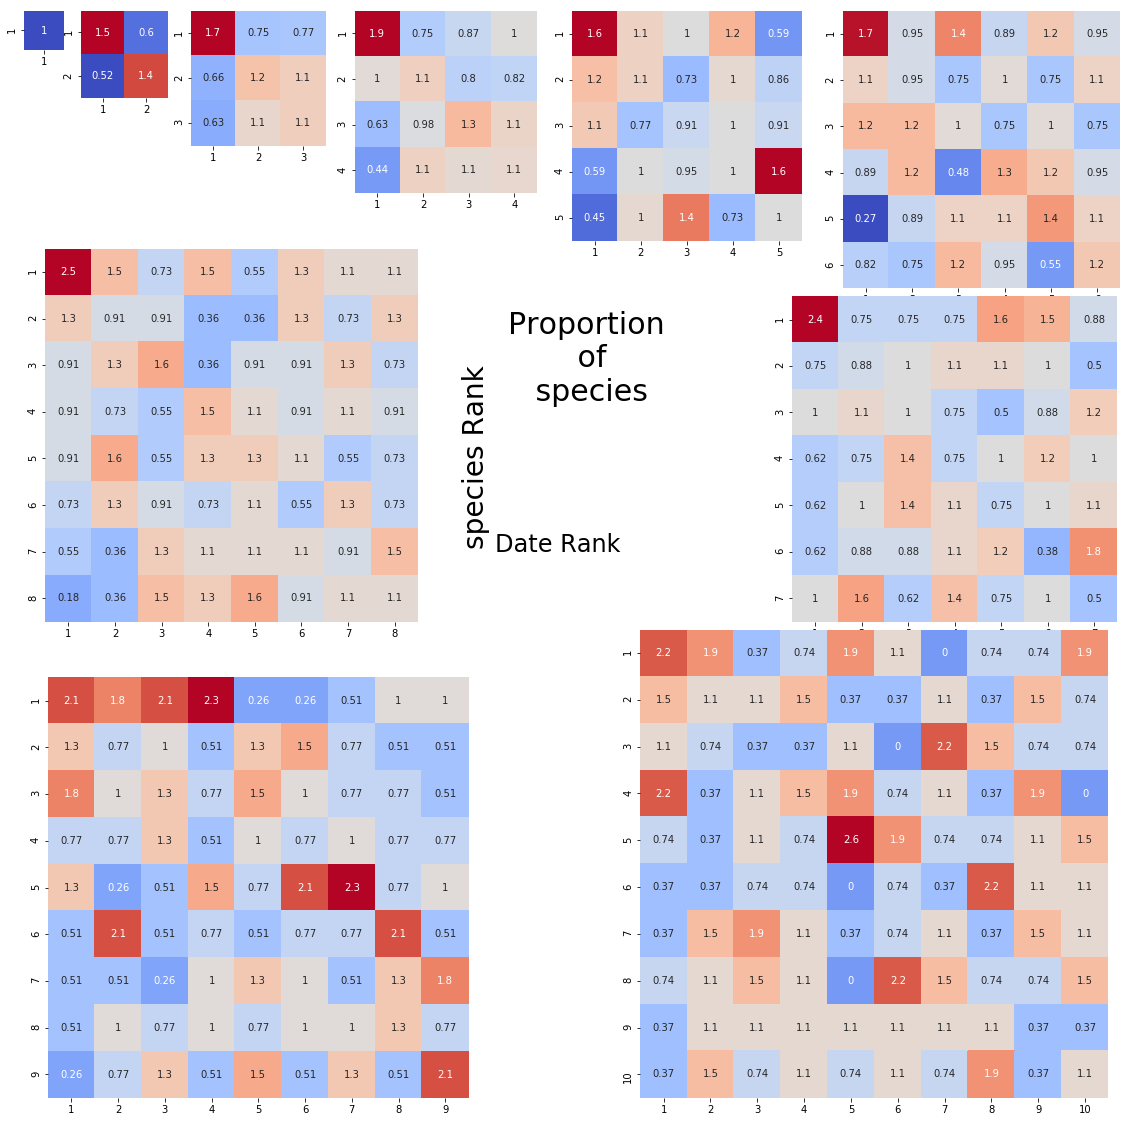

In [142]:
unaggHeatMapper(realtabs)#, func = pVal, center = .1, colormap = 'coolwarm_r')

In [165]:
%%time
epochs = [1758, 1815, 1916, 2020]
epochTabs = epochSplitter(dfp, 'SDate', epochs)
epochAggs = {k:speciesRankDateAgg(epochTabs[k]) for k in epochTabs}

Wall time: 17.5 s


In [166]:
epochAggs[list(epochAggs.keys())[0]]

{1: {1: [184, 76.402406130928156, 279],
  2: [57, 76.402406130928156, 279],
  3: [15, 40.902406130928185, 208],
  4: [10, 22.569072797594835, 153],
  5: [6, 14.56907279759484, 121],
  6: [3, 10.769072797594841, 102],
  7: [2, 7.6024061309281743, 83],
  8: [2, 5.8881204166424581, 71],
  9: [0, 4.1381204166424581, 57],
  10: [0, 3.4714537499757911, 51],
  11: [0, 2.771453749975791, 44],
  12: [0, 2.1350901136121552, 37],
  13: [0, 1.7184234469454884, 32],
  14: [0, 1.4107311392531809, 28],
  15: [0, 0.91073113925318139, 21],
  16: [0, 0.64406447258651467, 17],
  17: [0, 0.58156447258651467, 16],
  18: [0, 0.52274094317474984, 15],
  19: [0, 0.52274094317474984, 15],
  20: [0, 0.41747778528001306, 13],
  21: [0, 0.41747778528001306, 13],
  22: [0, 0.41747778528001306, 13],
  23: [0, 0.41747778528001306, 13],
  24: [0, 0.33052126354088268, 11],
  25: [0, 0.24718793020754937, 9],
  26: [0, 0.24718793020754937, 9],
  27: [0, 0.20872639174601088, 8],
  28: [0, 0.13465231767193681, 6],
  29: [

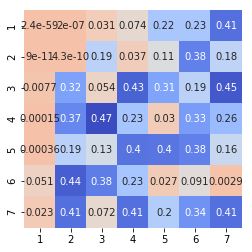

In [168]:
aggHeatMapper(realAgg, **hMapDefaults['pVal'], start = 1, end = 7)

In [261]:
import scipy.stats as stats

def absZScore(obs, exp, n):
    if n == 0:
        return 0
    elif obs == exp:
        return 0
    else:
        return abs(((obs/n - exp/n)/ (((exp/n)*(1-(exp/n)))/n)**.5))
def absZScoreApply(entry):
    return absZScore(*entry)

def prop(obs, exp, n):
    if exp == 0:
        return 0
    else:
        return obs / exp
def propApply(entry):
    return prop(*entry)

def pVal(obs, exp, n):
    return stats.norm.cdf(-absZScore(obs, exp, n))
def pValApply(entry):
    return stats.norm.cdf(-absZScoreApply(*entry))

def counts(obs, exp, n):
    return obs
def countsApply(entry):
    return counts(*entry)

hMapDefaults = { 'prop':{
                'func' : propApply,
                'center':1,
                'cmap' : 'coolwarm'}, 
               'z':{
                   'func' : absZScoreApply,
                   'center':1.64,
                   'cmap':'coolwarm'},
               'pVal':{
                   'func': pValApply,
                   'center': .10,
                   'cmap': 'coolwarm_r'
               }}

def aggHeatMapper(agg,  title = '', func = propApply, center = 1, cmap = 'coolwarm', start = 1, end = 10):
    df = pd.DataFrame(agg)
    df = df.loc[start:end, start:end]
    for c in df:
        df[c] = df[c].apply(func)
    sns.heatmap(df, annot = True, center = center,
               cmap = cmap, square = True,
               cbar = False)
    plt.title(title)

In [13]:
cts = authorCounts(df)

spg = df.groupby(['SpG'])['Genus'].unique()
spg = spg.apply(len)

spa = cts['SpAuthored'].value_counts()
gpa = cts['GenAuthored'].value_counts()

spg = ('Species', 'Genus', spg, sum([idx*spg[idx] for idx in spg.index]))
spa = ('Species', 'Author', spa, sum([idx*spa[idx] for idx in spa.index]))
gpa = ('Genera', 'Author', gpa, sum([idx*gpa[idx] for idx in gpa.index]))

370
968
linnaeus      718
sclater pl    465
gould         417
vieillot      399
gmelin jf     369
Name: SpAuthored, dtype: int64
bonaparte      164
cabanis        127
reichenbach    108
lesson r       106
swainson       101
Name: GenAuthored, dtype: int64


In [ ]:
def dirReduc(arr):
    arr = [e.upper() for e in arr]
    opposite = {"NORTH":"SOUTH",
                "SOUTH":"NORTH",
                "WEST":"EAST",
                "EAST":"WEST"}
    for i in range(len(arr)-1):
        if opposite[arr[i]] == arr[i]:
            arr.pop(i)
            arr.pop(i)
            dirReduc(arr)
        else:
            pass
    return arr

In [47]:
def dirReduc(arr):
    arr = [e.upper() for e in arr]
    opposite = {"NORTH":"SOUTH",
                "SOUTH":"NORTH",
                "WEST":"EAST",
                "EAST":"WEST"}
    
    prevLen = len(arr)
    changed = True
    while (len(arr)>1):
        for i in range(len(arr)-1):
            if opposite[arr[i]] == arr[i+1]:
                
                arr.pop(i)
                arr.pop(i)
                print(arr)
                break

    
    return arr

z=dirReduc(['NORTH', 'SOUTH', 'SOUTH', 'EAST', 'WEST', 'NORTH', 'WEST'])

['SOUTH', 'EAST', 'WEST', 'NORTH', 'WEST']
['SOUTH', 'NORTH', 'WEST']
['WEST']


In [48]:
z

['WEST']

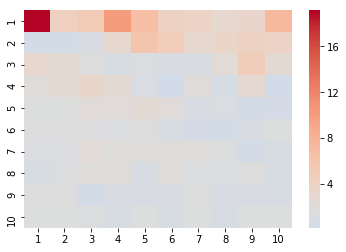

In [47]:
t = pd.DataFrame(testAgg).loc[1:10,1:10]
for c in t:
    t[c] = t[c].apply(absZScore)
    
#t = t.apply(absZScore, axis = 0)
sns.heatmap(t, cmap = 'coolwarm', center = 1.64);